### 平均地価との差分等を加えていく

LogRegressionPredictor...logを取ってクロスバリデーションで学習してくれるクラス  
save_data...trainの予測値と,testの予測値をいつも同じ形で保存するための関数  

In [1]:
# coding:utf-8
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import datetime
import seaborn as sns
sns.set()
import matplotlib

pd.set_option('max_columns',1000)
pd.set_option('max_rows',1000)


import warnings
warnings.filterwarnings('ignore')

import re
import geocoder
from geopy.distance import great_circle, vincenty
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import os
import gc
import lightgbm as lgb
from sklearn.model_selection import KFold, train_test_split
from time import time
import datetime
from script import RegressionPredictor,LogRegressionPredictor
import japanize_matplotlib
from utils import save_data
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
SEED=1234
n_splits=10

In [32]:
train=pd.read_csv('../higuchi/input/prep_train1107.csv')
test=pd.read_csv('../higuchi/input/prep_test1107.csv')
#train=pd.read_csv('../higuchi/input/train.csv')
#test=pd.read_csv('../higuchi/input/test.csv')
y_train = train['賃料']

In [33]:
drop_col = ['id']

## 必要な特徴量に絞る
y_train = train['賃料']
y_train_log = np.log1p(y_train)
X_train = train.drop(drop_col,axis=1)
X_test = test.drop(drop_col,axis=1)

### clustering

In [4]:
def get_Kmeans(X_train,X_test,n_clusters=300,cols=['loc_lat','loc_lon','築年数'],out_col='km_type_with_age',seed=42):
    std=StandardScaler()
    
    X = X_train[cols]
    X2= X_test[cols]
    Z=pd.concat([X,X2],axis=0)
    Z=std.fit_transform(Z)

    pred = KMeans(n_clusters=n_clusters,random_state=seed).fit_predict(Z)
    X_train[out_col]=pred[:X_train.shape[0]]
    X_test[out_col]=pred[X_train.shape[0]:]
    return X_train,X_test

In [ ]:
train

In [ ]:
normal_cols=['面積','築年数','center_dis', 'L','loc_lat','loc_lon','総階数','所在階','地価_neighbor_1''利用可能駅最大乗降人数','上昇率']
area_cols=['面積','築年数','center_dis','loc_lat','loc_lon','総階数','畳','所在階', '地価(単位面積)_neighbor_1','最短駅m', '最短駅乗降人数', '利用可能駅最大乗降人数', '上昇率']

In [ ]:
'km_type_with_age_地価_mean', '地価x面積', 'area_diff','area_ratio',
           'age_diff', 'age_ratio','area/ageratio', '地価x面積/築年数ratio',

In [5]:
X_train['地価'] = X_train['賃料'] / X_train['面積']

In [6]:
def feature_encoding(train, test, category_col, target_col, func_list):
    '''target_encodingを重要な列（面積など）でやる。TEと違って、test_dfに含まれる値も集計して作る'''
    data=pd.concat([train,test],axis=0).reset_index()
    
    agg_func = {target_col: func_list}
    #agg_funcでgruopby
    agg_df = data.groupby(category_col)[target_col].agg(agg_func)
    #列名作成
    agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]
    #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
    for col in agg_df.columns.values:
        train[col] = train[category_col].map(agg_df[col]).copy()
        test[col] = test[category_col].map(agg_df[col]).copy()
    return train, test

def target_encoding(train, test, category_col, target_col, func_list):
    '''target_encodingをやる。func_listに辞書型で列と処理する関数(meanとか)を渡す'''
    
    agg_func = {target_col: func_list}
    #agg_funcでgruopby
    agg_df = train.groupby(category_col)[target_col].agg(agg_func)
    #列名作成
    agg_df.columns = [category_col + '_' + '_'.join(col).strip() for col in agg_df.columns.values]
    #元の列に集約結果をmapしその値をコピーし新規列に加え返す。
    for col in agg_df.columns.values:
        train[col] = train[category_col].map(agg_df[col]).copy()
        test[col] = test[category_col].map(agg_df[col]).copy()
    return train, test

### feature_encoding target_encoding

In [36]:
train=pd.read_csv('../higuchi/input/prep_train1107.csv')
test=pd.read_csv('../higuchi/input/prep_test1107.csv')

y_train = train['賃料']

In [37]:
train.head()

,id,契約期間,建物構造,所在階,方角,築年数,賃料,間取り,面積,駐車場,トイレなし,脱衣所,洗面台独立,専用バス,共同トイレ,専用トイレ,浴室乾燥機,温水洗浄便座,-,バス・トイレ別,シャワー,共同バス,追焚機能,バスなし,山手線,中央線,大江戸線,丸ノ内線,三田線,新宿線,総武線,東西線,有楽町線,日比谷線,西武池袋線,京王線,西武新宿線,東武東上線,浅草線,京浜東北線,千代田線,本線,南北線,小田急小田原線,田園都市線,京王井の頭線,池上線,東横線,京成本線,大井町線,半蔵門線,常磐線,世田谷線,目黒線,新築,畳,有線放送,インターネット対応,インターネット使用料無料,CATV,光ファイバー,高速インターネット,CSアンテナ,BSアンテナ,loc_lat,loc_lon,center_dis,city,city2,借家,契約期間(まで),【大学】_dis,【大学】_num,【レンタルビデオ】_dis,【レンタルビデオ】_num,【飲食店】_dis,【飲食店】_num,【公園】_dis,【公園】_num,【郵便局】_dis,【郵便局】_num,【総合病院】_dis,【総合病院】_num,【クリーニング】_dis,【クリーニング】_num,【小学校】_dis,【小学校】_num,【病院】_dis,【病院】_num,【コインパーキング】_dis,【コインパーキング】_num,【デパート】_dis,【デパート】_num,【月極駐車場】_dis,【月極駐車場】_num,【コンビニ】_dis,【コンビニ】_num,【図書館】_dis,【図書館】_num,【ドラッグストア】_dis,【ドラッグストア】_num,【幼稚園・保育園】_dis,【幼稚園・保育園】_num,【スーパー】_dis,【スーパー】_num,【学校】_dis,【学校】_num,【銀行】_dis,【銀行】_num,水道その他,フローリング,室内洗濯機置場,出窓,防音室,トランクルーム,二重サッシ,二世帯住宅,2面採光,ペアガラス,エアコン付,24時間換気システム,3面採光,冷房,地下室,オール電化,ガス暖房,汲み取り,床下収納,ガスその他,ウォークインクローゼット,室外洗濯機置場,バルコニー,排水その他,ルーフバルコニー,敷地内ごみ置き場,井戸,タイル張り,バリアフリー,専用庭,ロフト付き,公営水道,下水,プロパンガス,都市ガス,浄化槽,石油暖房,洗濯機置場なし,クッションフロア,シューズボックス,床暖房,エレベーター,戸建て,総階数,地下階数,納戸,部屋数,L,D,K,LDK,DK,カウンターキッチン,IHコンロ,L字キッチン,電気コンロ,コンロ設置可（コンロ4口以上）,コンロ設置可（コンロ3口）,コンロ設置可（口数不明）,コンロ3口,コンロ設置可（コンロ2口）,独立キッチン,コンロ2口,コンロ1口,冷蔵庫あり,コンロ4口以上,システムキッチン,コンロ設置可（コンロ1口）,ガスコンロ,給湯,loc_flag,駐輪場,バイク置き場,loc_type,sta_mean,sta_min,sta_max,nearest_sta,second_sta,third_sta,鑑定評価額_所在地,鑑定評価額_丁目,鑑定評価額_city2,鑑定評価額,1m2当たりの価格_所在地,1m2当たりの価格_丁目,1m2当たりの価格_city2,1m2当たりの価格,駅のサイズ(路線数),乗降人数,2012年平均単価,2017年平均単価,上昇率,2012平均単価_mean,2012平均単価_max,2012平均単価_min,2017平均単価_mean,2017平均単価_max,2017平均単価_min,上昇率_mean,上昇率_max,上昇率_min,地価(単位面積)_neighbor_1,地価(単位面積)_neighbor_2,地価(単位面積)_neighbor_3,地価_neighbor_1,地価_neighbor_2,地価_neighbor_3,地価_neighbor_mean,地価_neighbor_std,地価(単位面積)_neighbor_mean,地価(単位面積)_neighbor_std,地価(単位面積)_neighbor_1.1,地価(単位面積)_neighbor_2.1,地価(単位面積)_neighbor_3.1,地価_neighbor_1.1,地価_neighbor_2.1,地価_neighbor_3.1,地価_neighbor_mean.1,地価_neighbor_std.1,地価(単位面積)_neighbor_mean.1,地価(単位面積)_neighbor_std.1,x,y,利用可能駅数,利用可能路線数,最短駅m,最短駅路線数,利用可能駅最大路線数,最短駅乗降人数,利用可能駅最大乗降人数
0,1,24,RC（鉄筋コンクリート）,1.0,南東,117,75000.0,1K,20.01,-,0,0,0,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,1,0,1,0,0,1,1,35.748456,139.728800,8179.773244,北区,滝野川,0,0,461,1,0,0,378,1,1103,1,1246,1,0,0,0,0,495,2,0,0,0,0,0,0,0,0,588,1,0,0,956,1,0,0,311,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,12.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,空有,-,66.0,652.916349,573.716550,856.219373,西巣鴨駅,西ケ原四丁目駅,板橋駅,NaN,NaN,7.756000e+07,7.756000e+07,NaN,NaN,5.321000e+05,5.321000e+05,1.0,28807.0,488617.0,591280.0,21.0,488617.0,488617.0,488617.0,591280.0,591280.0,591280.0,21.0,21.0,21.0,439000.0,702000.0,384000.0,8784390.0,14047020.0,7683840.0,10171750.0,3.400896e+06,5.083333e+05,169959.799168,439000.0,702000.0,384000.0,8784390.0,14047020.0,7683840.0,10171750.0,3.400896e+06,5.083333e+05,169959.799168,-27902.611016,-9454.034370,9.0,5.0,559.350481,1.0,2.0,28807.0,124386.0
1,2,24,鉄骨造,5.0,NaN,538,76000.0,1R,16.50,無,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,1,0,0,0,0,0,0,35.662885,139.778627,3368.632618,中央区,月島,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1283,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,10.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,空有,-,76.0,580.861502,505.869208,783.169958,勝どき駅,月島駅,築地駅,NaN,402750000.0,2.939333e+08,4.027500e+08,NaN,1322500.0,1.191667e+06,1.322500e+06,1.0,99517.0,581252.0,735032.0,26.5,581252.0,581252.0,581252.0,735032.0,735032.0,735032.0,26.5,26.5,26.5,1210000.0,1240000.0,1280000.0,19965000.0,20460000.0,21120000.0,20515000.0,5.794610e+05,1.243333e+06,35118.845843,1210000.0,1240000.0,1280000.0,19965000.0,20460000.0,21120000.0,20515000.0,5.794610e+05,1.243333e+06,35118.845843,-37399.816864,-4952.918855,4.0,3.0,401.002872,1.0,2.0,99517.0,99517.0
2,3,24,RC（鉄筋コンクリート）,12.0,南,102,110000.0,1K,22.05,近隣,0,1,1,1,0,1,1,1

In [15]:
drop_col = ['id']

## 必要な特徴量に絞る
y_train = train['賃料']
y_train_log = np.log1p(y_train)
X_train = train.drop(drop_col,axis=1)
X_test = test.drop(drop_col,axis=1)

In [16]:
y_train_area = np.log1p(train['賃料'] / train['面積'])

In [17]:
%%time
X_train, X_test = get_Kmeans(X_train, X_test, n_clusters=300)

CPU times: user 1min 41s, sys: 1min 14s, total: 2min 55s
Wall time: 51.8 s


In [18]:
category_col='km_type_with_age'
X_train['地価'] = X_train['賃料'] / X_train['面積']
target_dict = {category_col: ['mean']}

for category_col, func_list in target_dict.items():
    X_train, X_test = feature_encoding(X_train, X_test, category_col, '地価', func_list)
    X_train, X_test = feature_encoding(X_train, X_test, category_col, '面積', func_list)
    X_train, X_test = feature_encoding(X_train, X_test, category_col, '築年数', func_list)

X_train['地価x面積'] = X_train['面積'] * X_train[f'{category_col}_地価_mean']
X_test['地価x面積'] = X_test['面積'] * X_test[f'{category_col}_地価_mean']

#自身の面積と
X_train['area_diff'] = X_train['面積'] - X_train[f'{category_col}_面積_mean']
X_train['area_ratio'] = X_train['面積'] / X_train[f'{category_col}_面積_mean']
X_test['area_diff'] = X_test['面積'] - X_test[f'{category_col}_面積_mean']
X_test['area_ratio'] = X_test['面積'] / X_test[f'{category_col}_面積_mean']

X_train['age_diff'] = X_train['築年数'] - X_train[f'{category_col}_築年数_mean']
X_train['age_ratio'] = X_train['築年数'] / X_train[f'{category_col}_築年数_mean']
X_test['age_diff'] = X_test['築年数'] - X_test[f'{category_col}_築年数_mean']
X_test['age_ratio'] = X_test['築年数'] / X_test[f'{category_col}_築年数_mean']

X_train['area/ageratio'] = X_train['area_ratio'] / X_train['age_ratio']
X_test['area/ageratio'] = X_test['area_ratio'] / X_test['age_ratio']

X_train['地価x面積'] = X_train['面積'] * X_train[f'{category_col}_地価_mean']
X_test['地価x面積'] = X_test['面積'] * X_test[f'{category_col}_地価_mean']
X_train['地価x面積/築年数ratio'] = X_train['地価x面積'] / X_train['age_ratio']
X_test['地価x面積/築年数ratio'] = X_test['地価x面積'] / X_test['age_ratio']


### 学習準備

In [19]:
lgbm_params = {
    'num_iterations': 50000,
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    #'reg_lambda': 68.19849585036235,
    'reg_lambda': 0.016248748215948162, 
    #'reg_alpha': 0.007585940082730346,
    'reg_alpha': 0.017583014822381796,
    #'colsample_bytree': 0.6,
    'colsample_bytree': 0.7,
    #'subsample': 0.5,
    'subsample': 1.0,
    #'max_depth': 8,
    'max_depth': 8,
    #'min_child_weight': 8,
    'min_child_weight': 25,
    'lambda': 1,
    'eta': 0.1,
    'verbose': 1,
    'random_state': 0,
    'early_stopping_round': 50
    }

lgbm_log_params=lgbm_params.copy()
lgbm_log_params['metric']='mae'
lgbm_log_params['learning_rate']=0.05

lgbm_x_params=lgbm_params.copy()
lgbm_x_params['metric']='cross_entropy'
lgbm_x_params['learning_rate']=0.05


In [20]:
X_train_ = X_train.copy()
X_test_ = X_test.copy()

In [21]:
X_train = X_train_.copy()
X_test = X_test_.copy()

In [22]:
# features =  ['面積','築年数','sta_min','center_dis','L','loc_lat','loc_lon','総階数','畳','所在階','loc_type_地価_mean',
#              '地価x面積', 'area_diff','area_ratio', 'age_diff', 'age_ratio','area/ageratio', '地価x面積/築年数ratio']

features =  ['面積','築年数',#'sta_min',
             'center_dis', 'L','loc_lat','loc_lon','総階数',
             #'畳',
             '所在階','km_type_with_age_地価_mean', '地価x面積', 'area_diff',
             'area_ratio', 'age_diff', 
             'age_ratio', #'area/ageratio', 
             '地価x面積/築年数ratio', 
             #'地価_neighbor_mean', '地価_neighbor_std', '地価(単位面積)_neighbor_mean', '地価(単位面積)_neighbor_std', 
             '地価_neighbor_1', #'地価(単位面積)_neighbor_1',
             #'利用可能駅数', '利用可能路線数', 
             #'最短駅m', '最短駅乗降人数',
             '利用可能駅最大乗降人数', 
             '上昇率'
            ]
X_train = X_train[features]
X_test = X_test[features]

In [23]:
#RegressionPredictorに渡す↓
folder=KFold(n_splits=10, shuffle=True, random_state=421)

### log_predict
今一番精度がいいのがこれ

In [25]:
X_train.columns = X_train.columns.str.encode('utf-8').str.decode('utf-8')
X_test.columns = X_test.columns.str.encode('utf-8').str.decode('utf-8')

In [26]:
cols = ['area', 'age', #'sta_min', 
        'center_dis', 'L', 'loc_lat', 'loc_lon', 'total_floor',
       #'tatami',
       'floor', 'km_type_with_age_area_mean', 'land_pricexarea', 'area_diff',
       'area_ratio', 'age_diff', 
       'age_ratio', #'area/ageratio',
       'land_pricexarea/ageratio', 
       #'lp_neighbor_mean', #'lp_neighbor_std', 'lp(area)_neighbor_mean', 'lp(area)_neighbor_std', 
       'lp_neighbor_1', #'lp(area)_neighbor_1',
       #'avail_station', 'avail_root',
       #'sta_min_m', 'sta_min_people',
        'sta_max_people',
        'upper_rate', 
       ]
X_train.columns = cols
X_test.columns = cols

Training on fold 1
Training until validation scores don't improve for 50 rounds
[5000]	training's l1: 0.0187115	valid_1's l1: 0.0528661
[10000]	training's l1: 0.00891058	valid_1's l1: 0.0499434
Early stopping, best iteration is:
[14467]	training's l1: 0.00552329	valid_1's l1: 0.0490213
Training on fold 2
Training until validation scores don't improve for 50 rounds
[5000]	training's l1: 0.0187298	valid_1's l1: 0.0499643
[10000]	training's l1: 0.00901028	valid_1's l1: 0.0471042
[15000]	training's l1: 0.00534484	valid_1's l1: 0.0461213
Early stopping, best iteration is:
[15757]	training's l1: 0.00500569	valid_1's l1: 0.0460412
Training on fold 3
Training until validation scores don't improve for 50 rounds
[5000]	training's l1: 0.0187627	valid_1's l1: 0.0524442
[10000]	training's l1: 0.0091636	valid_1's l1: 0.0491442
[15000]	training's l1: 0.00548236	valid_1's l1: 0.0479415
Early stopping, best iteration is:
[17207]	training's l1: 0.00457747	valid_1's l1: 0.0476651
Training on fold 4
Train

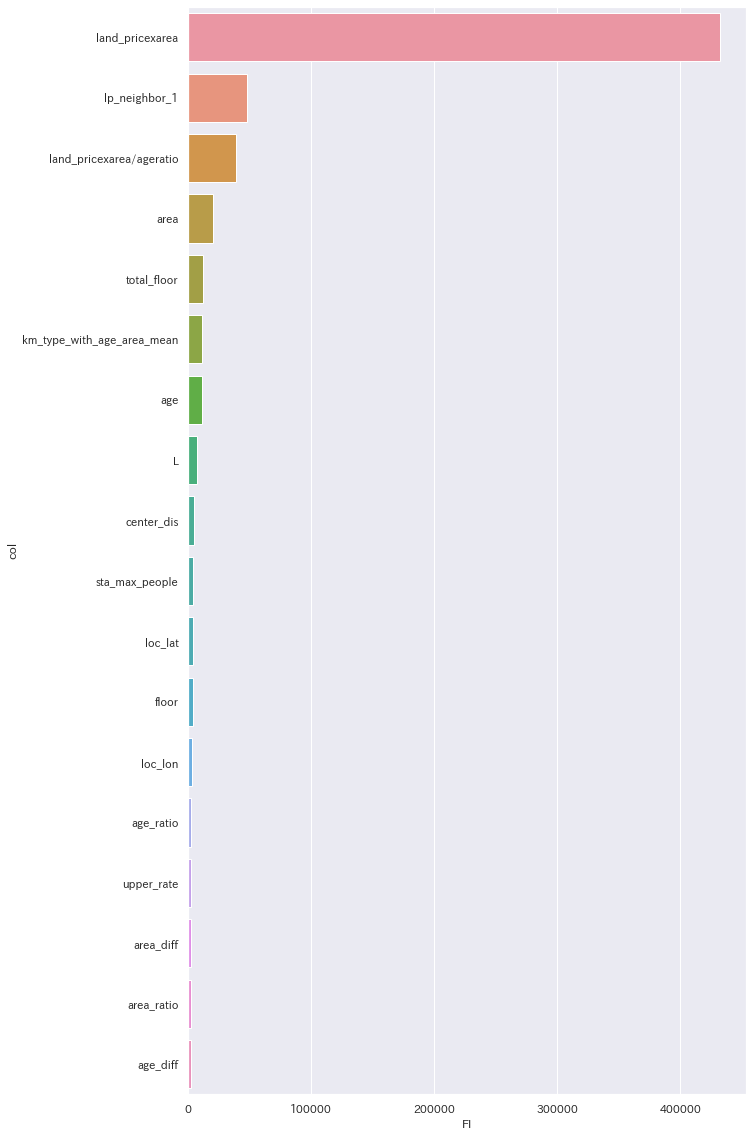

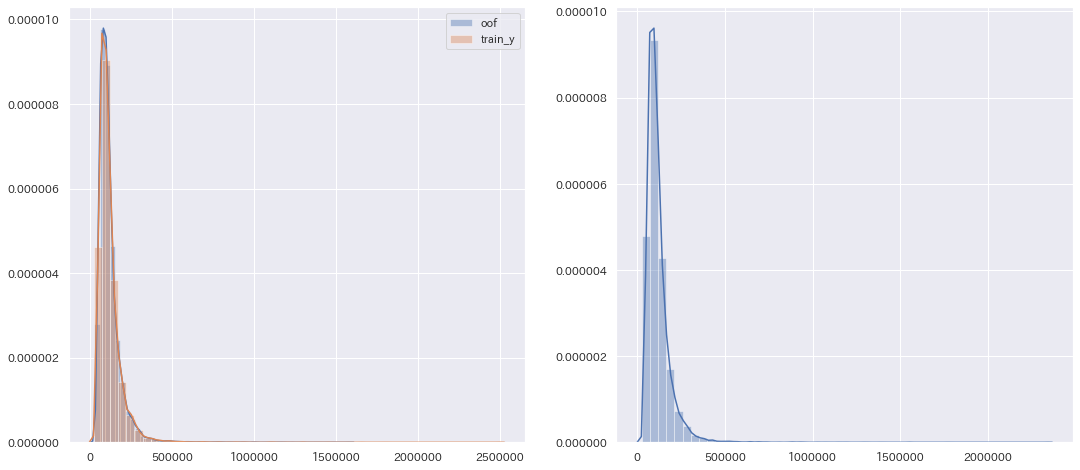

RMSE :  14899.496546247094
R^2 :  0.9557667439101908


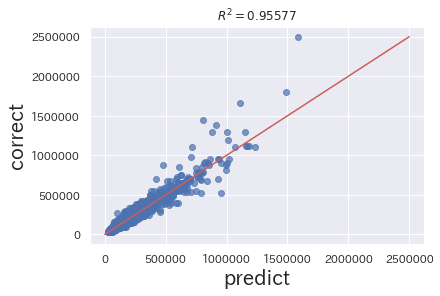

In [28]:
LogLGBM = LogRegressionPredictor(X_train, y_train.values, X_test, Folder=folder, params=lgbm_log_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
log_lgboof, log_lgbpreds, log_lgbFIs = LogLGBM.fit()
LogLGBM.plot_FI(50)
LogLGBM.plot_pred_dist()
LogLGBM.plot_scatter_oofvspred()


In [101]:
X_train_area = X_train_.copy()
X_test_area = X_test_.copy()

In [102]:
# features =  ['面積','築年数','sta_min','center_dis','L','loc_lat','loc_lon','総階数','畳','所在階','loc_type_地価_mean',
#              '地価x面積', 'area_diff','area_ratio', 'age_diff', 'age_ratio','area/ageratio', '地価x面積/築年数ratio']

features =  ['面積','築年数',#'sta_min',
             'center_dis',#'L',
             'loc_lat','loc_lon','総階数','畳','所在階','km_type_with_age_地価_mean', '地価x面積', 'area_diff',
             'area_ratio', 'age_diff', 'age_ratio',
             'area/ageratio', '地価x面積/築年数ratio', 
             #'地価_neighbor_mean', '地価_neighbor_std', '地価(単位面積)_neighbor_mean', '地価(単位面積)_neighbor_std', 
             #'地価_neighbor_1', #
             '地価(単位面積)_neighbor_1',
             #'利用可能駅数', '利用可能路線数', 
             '最短駅m', '最短駅乗降人数', '利用可能駅最大乗降人数', 
             #'防音室', '専用庭', 
             #'戸建て', 
             '上昇率'
            ]
X_train_area = X_train_area[features]
X_test_area = X_test_area[features]

In [103]:
#RegressionPredictorに渡す↓
folder=KFold(n_splits=10, shuffle=True, random_state=421)

### log_predict
今一番精度がいいのがこれ

In [104]:
X_train_area.columns = X_train_area.columns.str.encode('utf-8').str.decode('utf-8')
X_test_area.columns = X_test_area.columns.str.encode('utf-8').str.decode('utf-8')

In [105]:
cols = ['area', 'age', #'sta_min', 
        'center_dis', #'L', 
        'loc_lat', 'loc_lon', 'total_floor',
       'tatami', 'floor', 'km_type_with_age_area_mean', 'land_pricexarea', 'area_diff',
       'area_ratio', 'age_diff', 'age_ratio', 'area/ageratio',
       'land_pricexarea/ageratio', 
       #'lp_neighbor_mean', #'lp_neighbor_std', 'lp(area)_neighbor_mean', 'lp(area)_neighbor_std', 
       #'lp_neighbor_1', #
        'lp(area)_neighbor_1',
       #'avail_station', 'avail_root', 
        'sta_min_m', 'sta_min_people', 'sta_max_people', 
        #'no_noise', 'garden', 
        #'house',
        'upper_rate'
       ]
X_train_area.columns = cols
X_test_area.columns = cols

Training on fold 1
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.00208925	valid_1's l1: 0.00589765
[10000]	training's l1: 0.00114392	valid_1's l1: 0.00562927
Early stopping, best iteration is:
[12074]	training's l1: 0.000976386	valid_1's l1: 0.00558659
Training on fold 2
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.00209138	valid_1's l1: 0.00559591
[10000]	training's l1: 0.00114871	valid_1's l1: 0.00533745
Early stopping, best iteration is:
[12432]	training's l1: 0.000958744	valid_1's l1: 0.00529364
Training on fold 3
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.00209842	valid_1's l1: 0.0057847
[10000]	training's l1: 0.00115477	valid_1's l1: 0.00551922
Early stopping, best iteration is:
[12956]	training's l1: 0.000938235	valid_1's l1: 0.00546359
Training on fold 4
Training until validation scores don't improve for 50 rounds.
[5000]	training's l1: 0.00208216	valid_1'

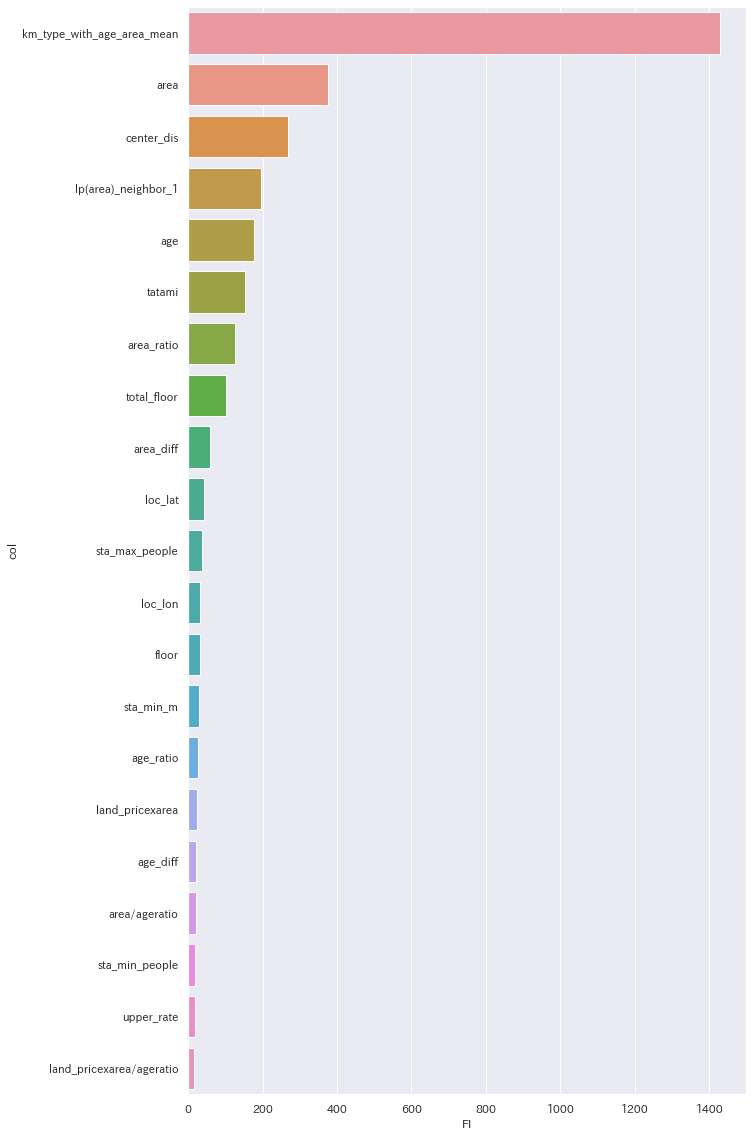

In [106]:
LogLGBM_area = LogRegressionPredictor(X_train_area, y_train_area.values, X_test_area, Folder=folder, params=lgbm_log_params,
                                      sk_model=None, n_splits=10, clf_type='lgb')
log_lgboof_area, log_lgbpreds_area, log_lgbFIs_area = LogLGBM_area.fit()
LogLGBM_area.plot_FI(50)
#LogLGBM_area.plot_pred_dist()
#LogLGBM_area.plot_scatter_oofvspred()

In [109]:
# 評価関数（RMSE）
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


賃料予測:  15237.574751471797
単位面積予測:  14898.775364687772
mean:  14523.263087248586
r2 = 0.9581962948565859


<Figure size 720x432 with 0 Axes>

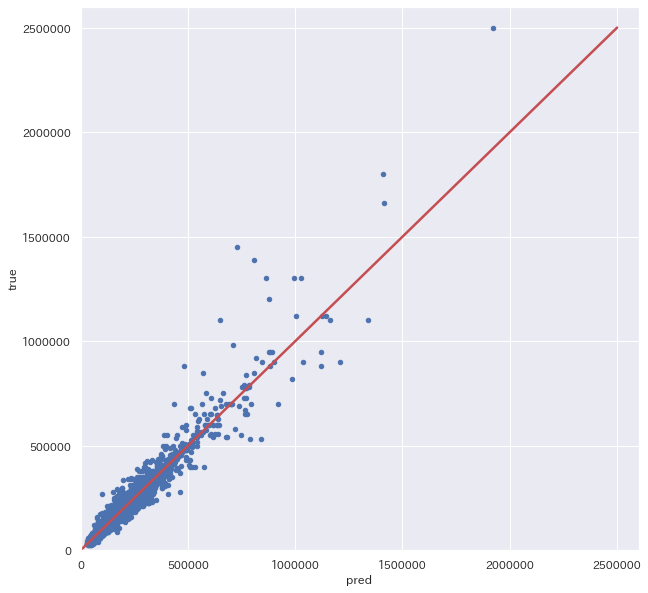

In [110]:
#それぞれあんま効いてないやつ削除
print('賃料予測: ', rmse(log_lgboof, y_train))
print('単位面積予測: ', rmse(np.exp(log_lgboof_area)*X_train_area['area'].values, y_train))
print('mean: ', rmse((log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, y_train))
from sklearn.metrics import r2_score
res = pd.DataFrame({'pred': (log_lgboof+np.exp(log_lgboof_area)*X_train_area['area'].values)/2, 'true': y_train})
print('r2 =', r2_score(res['pred'], res['true']))
plt.figure(figsize=(10, 6))
plt.subplot
res.plot.scatter(x='pred', y='true', figsize=(10, 10))
plt.plot([0, 2500000], [0, 2500000], color='r', linewidth=2.5)
plt.xlim(0,2600000)
plt.ylim(0,2600000)
plt.show()

In [360]:
save_data(X_train,log_lgboof, log_lgbpreds,rmse=LogLGBM.rmse(),name='log_tika_loc_type2',save_dir='./stacking')

,id,target
0,31471,132053.917433
1,31472,117256.666903
2,31473,75805.655838
3,31474,60408.675517
4,31475,104576.924170


,id,target
0,1,85764.494641
1,2,66001.551324
2,3,105966.359595
3,4,160027.116873
4,5,63334.636205
